In [1]:
from __future__ import print_function, division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
num_epochs = 100
total_series_length = 50000
truncated_backprop_length = 15
state_size = 4
num_classes = 2
echo_step = 3
batch_size = 5
num_batches = total_series_length//batch_size//truncated_backprop_length

In [3]:
def generateData():
    x = np.array(np.random.choice(2, total_series_length, p=[0.5, 0.5]))
    y = np.roll(x, echo_step)
    y[0:echo_step] = 0

    x = x.reshape((batch_size, -1))  # The first index changing slowest, subseries as rows
    y = y.reshape((batch_size, -1))

    return (x, y)

In [4]:
batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.int32, [batch_size, truncated_backprop_length])

cell_state = tf.placeholder(tf.float32, [batch_size, state_size])
hidden_state = tf.placeholder(tf.float32, [batch_size, state_size])
init_state = tf.contrib.rnn.LSTMStateTuple(cell_state, hidden_state)

W2 = tf.Variable(np.random.rand(state_size, num_classes),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1,num_classes)), dtype=tf.float32)

In [5]:
# Unpack columns
inputs_series = tf.split(batchX_placeholder, truncated_backprop_length, 1)
labels_series = tf.unstack(batchY_placeholder, axis=1)

# Forward passes
cell = tf.contrib.rnn.BasicLSTMCell(state_size, state_is_tuple=True)
states_series, current_state = tf.contrib.rnn.static_rnn(cell, inputs_series, init_state)

In [7]:
logits_series = [tf.matmul(state, W2) + b2 for state in states_series] #Broadcasted addition
predictions_series = [tf.nn.softmax(logits) for logits in logits_series]

losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels) for logits, labels in zip(logits_series,labels_series)]
total_loss = tf.reduce_mean(losses)

train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)

In [8]:
def plot(loss_list, predictions_series, batchX, batchY):
    plt.subplot(2, 3, 1)
    plt.cla()
    plt.plot(loss_list)

    for batch_series_idx in range(5):
        one_hot_output_series = np.array(predictions_series)[:, batch_series_idx, :]
        single_output_series = np.array([(1 if out[0] < 0.5 else 0) for out in one_hot_output_series])

        plt.subplot(2, 3, batch_series_idx + 2)
        plt.cla()
        plt.axis([0, truncated_backprop_length, 0, 2])
        left_offset = range(truncated_backprop_length)
        plt.bar(left_offset, batchX[batch_series_idx, :], width=1, color="blue")
        plt.bar(left_offset, batchY[batch_series_idx, :] * 0.5, width=1, color="red")
        plt.bar(left_offset, single_output_series * 0.3, width=1, color="green")

    plt.draw()
    plt.pause(0.0001)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


New data, epoch 0
Step 0 Batch loss 0.709135
Step 100 Batch loss 0.520601
Step 200 Batch loss 0.428233
Step 300 Batch loss 0.365698
Step 400 Batch loss 0.0179429
Step 500 Batch loss 0.00834771
Step 600 Batch loss 0.00575004
New data, epoch 1
Step 0 Batch loss 0.629686
Step 100 Batch loss 0.00338771
Step 200 Batch loss 0.00308497
Step 300 Batch loss 0.00303276
Step 400 Batch loss 0.00183209
Step 500 Batch loss 0.00177152
Step 600 Batch loss 0.00171834
New data, epoch 2
Step 0 Batch loss 0.540661
Step 100 Batch loss 0.00194967
Step 200 Batch loss 0.00146735
Step 300 Batch loss 0.00131602
Step 400 Batch loss 0.00113264
Step 500 Batch loss 0.000944204
Step 600 Batch loss 0.00111875
New data, epoch 3
Step 0 Batch loss 0.468308
Step 100 Batch loss 0.00094576
Step 200 Batch loss 0.000880749
Step 300 Batch loss 0.000939516
Step 400 Batch loss 0.000676153
Step 500 Batch loss 0.000680783
Step 600 Batch loss 0.000722903
New data, epoch 4
Step 0 Batch loss 0.635875
Step 100 Batch loss 0.000674456


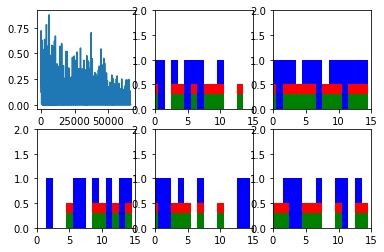

In [9]:
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    plt.ion()
    plt.figure()
    plt.show()
    loss_list = []

    for epoch_idx in range(num_epochs):
        x,y = generateData()
        _current_cell_state = np.zeros((batch_size, state_size))
        _current_hidden_state = np.zeros((batch_size, state_size))

        print("New data, epoch", epoch_idx)

        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length

            batchX = x[:,start_idx:end_idx]
            batchY = y[:,start_idx:end_idx]

            _total_loss, _train_step, _current_state, _predictions_series = sess.run(
                [total_loss, train_step, current_state, predictions_series],
                feed_dict={
                    batchX_placeholder: batchX,
                    batchY_placeholder: batchY,
                    cell_state: _current_cell_state,
                    hidden_state: _current_hidden_state

                })

            _current_cell_state, _current_hidden_state = _current_state

            loss_list.append(_total_loss)

            if batch_idx%100 == 0:
                print("Step",batch_idx, "Batch loss", _total_loss)
                plot(loss_list, _predictions_series, batchX, batchY)

plt.ioff()
plt.show()